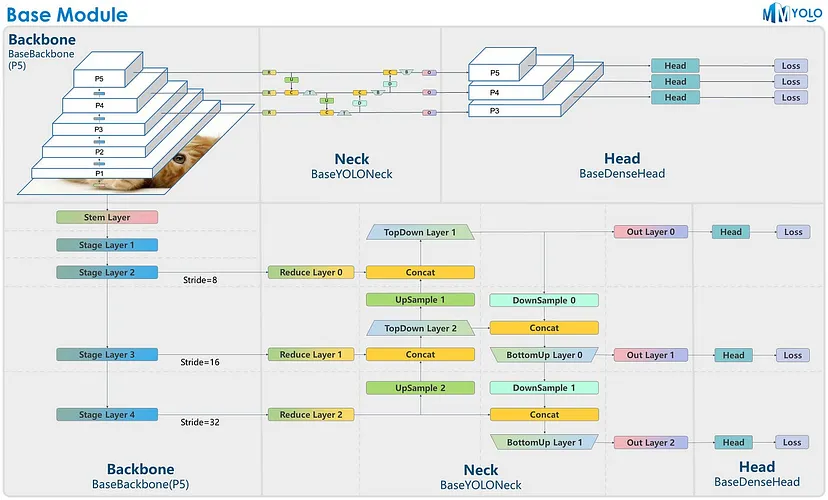

In [1]:
!pip install --quiet imutils
!pip install --quiet wget
!pip install --quiet split-folders
!pip install --quiet ultralytics

In [2]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.48 🚀 Python-3.10.14 torch-2.3.1+cu121 CUDA:0 (NVIDIA A10G, 22724MiB)
Setup complete ✅ (16 CPUs, 62.1 GB RAM, 95.8/135.0 GB disk)


In [4]:
from imutils import paths
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import splitfolders
from torch import nn
import numpy as np
import os
import wget
from PIL import Image
import cv2
import requests
import tarfile
# import tensorflow as tf
# from tensorflow.keras.preprocessing.image import img_to_array
# from tensorflow.keras.preprocessing.image import load_img

In [5]:
def download_and_extract(url, destination_folder):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Get the filename from the URL
    filename = os.path.join(destination_folder, url.split("/")[-1])

    # Download the file
    response = requests.get(url, stream=True)
    with open(filename, 'wb') as file:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                file.write(chunk)

    # Extract the contents of the tar.gz file
    with tarfile.open(filename, 'r:gz') as tar:
        tar.extractall(destination_folder)

    # Remove the downloaded compressed file
    os.remove(filename)

In [6]:
dataset_url = "http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz"

destination_folder = "flickr_logos_dataset"

download_and_extract(dataset_url, destination_folder)



In [8]:
fname = './flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

with tarfile.open(fname, 'r:gz') as tar:
    tar.extractall(destination_folder)

os.remove(fname)

In [9]:
txt_path = "./flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"

In [10]:
df = pd.read_csv(txt_path,
                 sep='\s+',
                 header=None)

In [11]:
df.shape

(4536, 7)

In [12]:
columns = ['filename', 'class', 'sub-class','xmin', 'ymin', 'xmax', 'ymax']


In [13]:
df.columns = columns

In [14]:
df.head(5)

,filename,class,sub-class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [15]:
classes = df['class'].unique().tolist()

In [16]:
print("Classess = ",classes)
print("\n\nTotal Classess = ",len(classes))

Classess =  ['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 'Ford', 'Google', 'Heineken', 'HP', 'Intel', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo']


Total Classess =  27


In [17]:
class_mapping = {class_name: i for i, class_name in enumerate(classes)}

for class_name, class_no in class_mapping.items():
    print(f"{class_name}: {class_no}")

Adidas: 0
Apple: 1
BMW: 2
Citroen: 3
Cocacola: 4
DHL: 5
Fedex: 6
Ferrari: 7
Ford: 8
Google: 9
Heineken: 10
HP: 11
Intel: 12
McDonalds: 13
Mini: 14
Nbc: 15
Nike: 16
Pepsi: 17
Porsche: 18
Puma: 19
RedBull: 20
Sprite: 21
Starbucks: 22
Texaco: 23
Unicef: 24
Vodafone: 25
Yahoo: 26


## Removing Invalid Images and Invalid Bounding Boxes

In [18]:
def is_valid_image(img_path):
    try:
        Image.open(img_path).verify()
        return True
    except (IOError, SyntaxError):
        return False

def remove_broken_and_invalid_entries(folder_path, annotation_file_path):

    total_images_before = len(os.listdir(folder_path))

    with open(annotation_file_path, 'r') as file:
        total_entries_before = len(file.readlines())

    # Read the annotation file into a list
    with open(annotation_file_path, 'r') as file:
        annotations = file.readlines()

    # Filter out broken and invalid entries
    valid_annotations = []
    for annotation in annotations:
        parts = annotation.split()
        img_name, class_name, _, xmin, ymin, xmax, ymax = parts

        # Check if image is valid
        img_path = os.path.join(folder_path, img_name)
        if not is_valid_image(img_path):
            continue

        # Check if bounding box is valid
        xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
        if xmin >= xmax or ymin >= ymax:
            continue

        # If both checks pass, add the annotation to the valid list
        valid_annotations.append(annotation)

    # Update the annotation file
    with open(annotation_file_path, 'w') as file:
        file.writelines(valid_annotations)

    # Remove broken and invalid images
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            img_path = os.path.join(root, file)
            if not is_valid_image(img_path):
                os.remove(img_path)
            else:
                img_name = file
                annotation_exists = any(img_name in annotation for annotation in valid_annotations)
                if not annotation_exists:
                    print(img_path)
                    os.remove(img_path)

    # Count the total number of images after removal
    total_images_after = len(os.listdir(folder_path))

    total_entries_after = len(valid_annotations)

    print(f"Total number of entries before: {total_entries_before}")
    print(f"Total number of entries after Removal: {total_entries_after}")

    print(f"Total number of images before Removal: {total_images_before}")
    print(f"Total number of images after Removal: {total_images_after}")

In [19]:
folder_path = "./flickr_logos_dataset/flickr_logos_27_dataset_images"
annotation_file_path = "./flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt"
remove_broken_and_invalid_entries(folder_path, annotation_file_path)

./flickr_logos_dataset/flickr_logos_27_dataset_images/3489974023.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3411396204.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3107265036.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/2485192693.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3459680851.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/2256917485.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3570289087.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3420119175.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3842830049.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3433571555.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3385050449.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/4605630935.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/2974513280.jpg
./flickr_logos_dataset/flickr_logos_27_dataset_images/3131641312.jpg
./flickr_logos_dataset/flickr_logo

In [20]:
df = pd.read_csv("./flickr_logos_dataset/flickr_logos_27_dataset/flickr_logos_27_dataset_training_set_annotation.txt",
                 sep='\s+',
                 header=None)
df.shape

(4531, 7)

In [21]:
df.columns = columns

In [22]:
df.head(5)

,filename,class,sub-class,xmin,ymin,xmax,ymax
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


## Preparing the Dataset

In [23]:
IMAGES_FOLDER_PATH = './flickr_logos_dataset/flickr_logos_27_dataset_images'
OUTPUT_FOLDER_PATH = 'LOGOS'

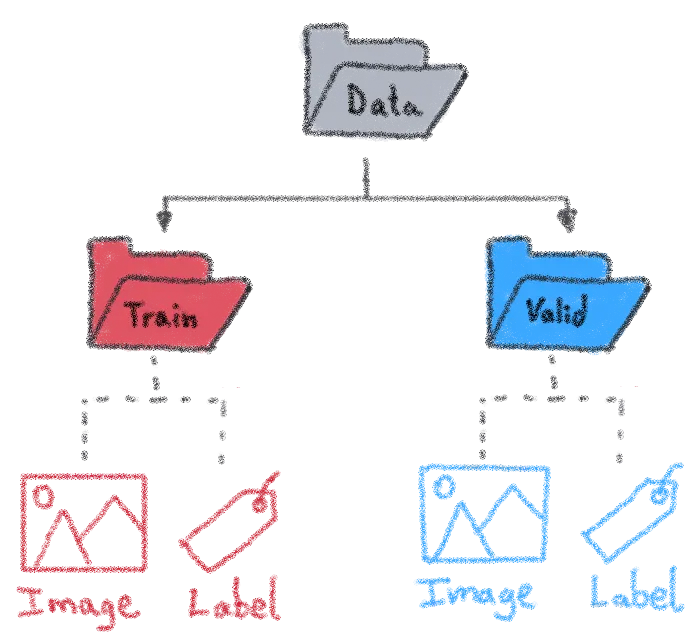

In [24]:
# Create folders
output_images_folder = os.path.join(OUTPUT_FOLDER_PATH, 'images')
output_labels_folder = os.path.join(OUTPUT_FOLDER_PATH, 'labels')
os.makedirs(output_images_folder, exist_ok=True)
os.makedirs(output_labels_folder, exist_ok=True)

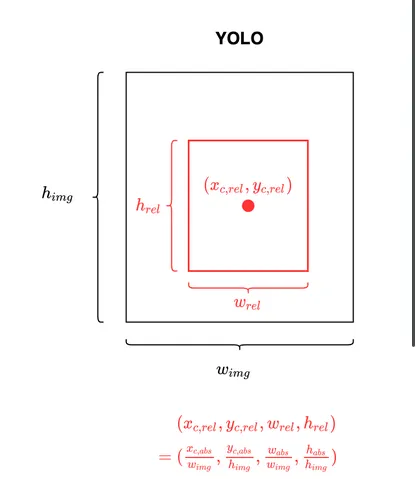

In [32]:
from tqdm import tqdm

for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
    filename = row['filename']
    class_name = row['class']
    xmin, ymin, xmax, ymax = row['xmin'], row['ymin'], row['xmax'], row['ymax']

    # Read image
    image_path = os.path.join(IMAGES_FOLDER_PATH, filename)
    image = Image.open(image_path).convert("RGB")
    image_w, image_h = image.size

    # Calculate normalized bounding box coordinates
    b_center_x = (xmin + xmax) / 2
    b_center_y = (ymin + ymax) / 2
    b_width = (xmax - xmin)
    b_height = (ymax - ymin)

    b_center_x /= image_w
    b_center_y /= image_h
    b_width /= image_w
    b_height /= image_h

    # Save image
    output_image_path = os.path.join(output_images_folder, filename)
    image.save(output_image_path)

    # Save label file
    label_filename = os.path.splitext(filename)[0] + '.txt'
    label_path = os.path.join(output_labels_folder, label_filename)
    with open(label_path, 'w') as label_file:
        class_id = class_mapping[class_name]
        label_file.write(f"{class_id} {b_center_x} {b_center_y} {b_width} {b_height}")

print("Processing complete.")

Processing complete.


In [33]:
label_path = './LOGOS/labels/2675240646.txt'
img = './LOGOS/images/2675240646.jpg'
image = cv2.imread(img)

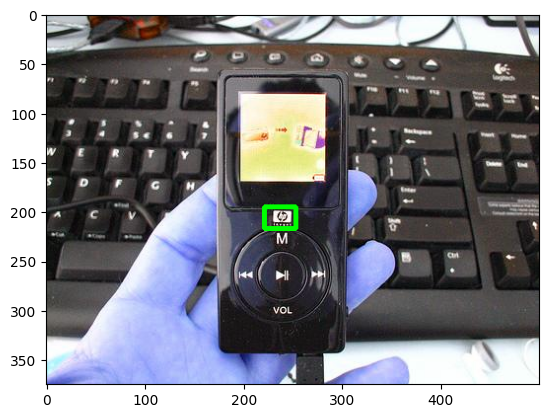

In [34]:
with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")
        for label in labels:
            class_id, x_center, y_center, width, height = map(float, label.split())
            x_min = int((x_center - width/2) * image.shape[1])
            y_min = int((y_center - height/2) * image.shape[0])
            x_max = int((x_center + width/2) * image.shape[1])
            y_max = int((y_center + height/2) * image.shape[0])
            cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)
            plt.imshow(image)

In [35]:
splitfolders.ratio('./LOGOS', output="data", seed=42, ratio=(0.8,0.2))


Copying files: 1616 files [00:41, 39.39 files/s]


In [43]:
from ultralytics import YOLO

In [41]:
model = YOLO("yolov8x.pt")
dict_classes = model.model.names

In [42]:
dict_classes

{0: 'person',
 1: 'bicycle',
 2: 'car',
 3: 'motorcycle',
 4: 'airplane',
 5: 'bus',
 6: 'train',
 7: 'truck',
 8: 'boat',
 9: 'traffic light',
 10: 'fire hydrant',
 11: 'stop sign',
 12: 'parking meter',
 13: 'bench',
 14: 'bird',
 15: 'cat',
 16: 'dog',
 17: 'horse',
 18: 'sheep',
 19: 'cow',
 20: 'elephant',
 21: 'bear',
 22: 'zebra',
 23: 'giraffe',
 24: 'backpack',
 25: 'umbrella',
 26: 'handbag',
 27: 'tie',
 28: 'suitcase',
 29: 'frisbee',
 30: 'skis',
 31: 'snowboard',
 32: 'sports ball',
 33: 'kite',
 34: 'baseball bat',
 35: 'baseball glove',
 36: 'skateboard',
 37: 'surfboard',
 38: 'tennis racket',
 39: 'bottle',
 40: 'wine glass',
 41: 'cup',
 42: 'fork',
 43: 'knife',
 44: 'spoon',
 45: 'bowl',
 46: 'banana',
 47: 'apple',
 48: 'sandwich',
 49: 'orange',
 50: 'broccoli',
 51: 'carrot',
 52: 'hot dog',
 53: 'pizza',
 54: 'donut',
 55: 'cake',
 56: 'chair',
 57: 'couch',
 58: 'potted plant',
 59: 'bed',
 60: 'dining table',
 61: 'toilet',
 62: 'tv',
 63: 'laptop',
 64: 'mou

## Setting up the YAML file

In [44]:
import yaml

In [56]:
data = {'train' :  '/home/ec2-user/SageMaker/efs/Projects/ultralytics/data/train',
        'val' :  '/home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val',
        'test' :  '/home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val',
        'nc': len(classes),
        'names': classes
        }

In [57]:
file_path = './data/data.yaml'
with open(file_path, 'w') as f:
    yaml.dump(data, f)

In [58]:
# read the content in .yaml file
with open('./data/data.yaml', 'r') as f:
    hamster_yaml = yaml.safe_load(f)
    display(hamster_yaml)

{'names': ['Adidas',
  'Apple',
  'BMW',
  'Citroen',
  'Cocacola',
  'DHL',
  'Fedex',
  'Ferrari',
  'Ford',
  'Google',
  'Heineken',
  'HP',
  'Intel',
  'McDonalds',
  'Mini',
  'Nbc',
  'Nike',
  'Pepsi',
  'Porsche',
  'Puma',
  'RedBull',
  'Sprite',
  'Starbucks',
  'Texaco',
  'Unicef',
  'Vodafone',
  'Yahoo'],
 'nc': 27,
 'test': '/home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val',
 'train': '/home/ec2-user/SageMaker/efs/Projects/ultralytics/data/train',
 'val': '/home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val'}

In [59]:
print(len(model.names)) # 80 COCO dataset labels

80


In [61]:
data_path = './data/data.yaml'

## Finetuning

In [ ]:
model.train(data=data_path, epochs=50, batch=4)

New https://pypi.org/project/ultralytics/8.2.50 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.2.48 🚀 Python-3.10.14 torch-2.3.1+cu121 CUDA:0 (NVIDIA A10G, 22724MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=./data/data.yaml, epochs=50, time=None, patience=100, batch=4, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train8, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=Fa

train: Scanning /home/ec2-user/SageMaker/efs/Projects/ultralytics/data/train/labels.cache... 646 images, 0 backgrounds, 0 corrupt: 100%|██████████| 646/646 [00:00<?, ?it/s]
val: Scanning /home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val/labels.cache... 162 images, 0 backgrounds, 0 corrupt: 100%|██████████| 162/162 [00:00<?, ?it/s]


Plotting labels to runs/detect/train8/labels.jpg... 


## Prediction

In [65]:
def predict(src):
    result_predict = model.predict(source = src)
    plot = result_predict[0].plot()
    plot = cv2.cvtColor(plot, cv2.COLOR_BGR2RGB)
    display(Image.fromarray(plot))



image 1/1 /home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val/images/2126991906.jpg: 192x640 1 Yahoo, 105.8ms
Speed: 0.7ms preprocess, 105.8ms inference, 1.1ms postprocess per image at shape (1, 3, 192, 640)


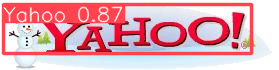

In [66]:
path = './data/val/images/2126991906.jpg'
predict(path)


image 1/1 /home/ec2-user/SageMaker/efs/Projects/ultralytics/data/val/images/1690276845.jpg: 480x640 1 Porsche, 124.3ms
Speed: 1.6ms preprocess, 124.3ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)


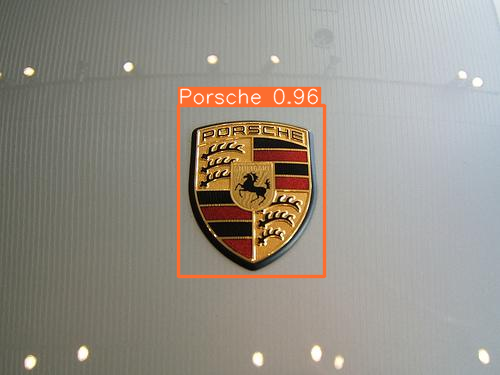

In [67]:
path = './data/val/images/1690276845.jpg'
predict(path)